<a href="https://colab.research.google.com/github/chwankai/Flight_Ticket_Fares_using_Machine_Learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -----------------------------------------
# |TML6223 Machine Learning - Project     |
# |ML1 (Section 1G) - Group 6             |
# |Title: Air Ticket Price Prediction     |
# -----------------------------------------
# |242UT2449P SEE CHWAN KAI               |
# |242UT24490 TEO JING AN                 |
# |242UT244B2 TEE KIAN HAO                |
# |242UT2449Z KHO WEI CONG                |
# -----------------------------------------

# Google Colab Link: https://colab.research.google.com/drive/1H0yM9mgs3D5j3Mu5qdijOXoG4hvrj6-W#scrollTo=z-ReH6pR3ga4
# Kaggle Link: https://www.kaggle.com/datasets/justinmitchel/flightprices-min?resource=download

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Load the dataset
train = pd.read_csv('/content/sample_data/itineraries-min-50k.csv')

# Show dirty data - 50000 rows
train.count()

,0
legId,50000
searchDate,50000
flightDate,50000
startingAirport,50000
destinationAirport,50000
fareBasisCode,50000
travelDuration,50000
elapsedDays,50000
isBasicEconomy,50000
isRefundable,50000


In [ ]:
## Preprocessing and cleaning data

# Define features to use for prediction and the target variable
features = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'seatsRemaining', 'fareBasisCode',
            'travelDuration', 'segmentsAirlineCode', 'segmentsCabinCode', 'totalTravelDistance','flightDate']
target = 'baseFare'

# Keep only relevant columns and drop rows with any missing values
train = train[features + [target]].dropna()

# Extract the first cabin code if multiple are present in 'segmentsCabinCode'
def clean_segments_airline_code(val):
    try:
        return str(val).split('||')[0].strip() if val else np.nan
    except:
        return np.nan

train['segmentsAirlineCode'] = train['segmentsAirlineCode'].apply(clean_segments_airline_code)

# Extract the first cabin code if multiple are present in 'segmentsCabinCode'
def clean_segments_cabin_code(val):
    try:
        return str(val).split('||')[0].strip() if val else np.nan
    except:
        return np.nan

train['segmentsCabinCode'] = train['segmentsCabinCode'].apply(clean_segments_cabin_code)

# Drop rows where cleaned 'segmentsCabinCode' is missing
train.dropna(subset=['segmentsCabinCode'], inplace=True)

# Convert ISO 8601 duration strings (e.g., "PT2H45M") to total duration in minutes
def convert_duration_to_minutes(duration):
    try:
        hours, minutes = 0, 0
        if isinstance(duration, str):
            if 'H' in duration:
                hours = int(duration.split('H')[0].replace('PT', ''))
            if 'M' in duration:
                if 'H' in duration:
                    minutes = int(duration.split('H')[1].replace('M', ''))
                else:
                    minutes = int(duration.replace('PT', '').replace('M', ''))
        return hours * 60 + minutes
    except:
        return np.nan

train['travelDuration'] = train['travelDuration'].apply(convert_duration_to_minutes)

# Drop rows with any missing values after duration conversion
train.dropna(inplace=True)

# Feature Engineering
train['fareClass'] = train['fareBasisCode'].str[0]
train['numStops'] = train['segmentsCabinCode'].str.count('||') # Number of legs = stops + 1
train['flightDate'] = pd.to_datetime(train['flightDate']) # convert to proper date format
train['flightMonth'] = train['flightDate'].dt.month #create new column called flightMonth from flightDay
train['flightDayOfWeek'] = train['flightDate'].dt.dayofweek #create new column called flightDateOfWeek from flightDay

# Remove outliers in the target variable by keeping only rows between the 1st and 99th percentiles
lower_bound = train[target].quantile(0.01)
upper_bound = train[target].quantile(0.99)
train = train[(train[target] >= lower_bound) & (train[target] <= upper_bound)]

# Separate feature matrix (X) and target variable (y)
X = train.drop(target, axis=1)
y = train[target]

# Identify categorical and numerical feature columns
categorical_cols = ['flightMonth', 'flightDayOfWeek','startingAirport', 'destinationAirport', 'segmentsAirlineCode', 'segmentsCabinCode', 'fareClass']
numerical_cols = ['isBasicEconomy', 'isRefundable', 'travelDuration', 'totalTravelDistance','isNonStop', 'seatsRemaining','numStops']

# Build a preprocessing pipeline:
# - Standardize numerical features (Standard Scaler)
# - One-hot encode categorical features (One Hot Encoder)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Select and transform the features
X = train[categorical_cols + numerical_cols]
y = train[target]

# Process the data
X_processed = preprocessor.fit_transform(X)

# Show clean data rows
train.count()

,0
startingAirport,46722
destinationAirport,46722
isBasicEconomy,46722
isRefundable,46722
isNonStop,46722
seatsRemaining,46722
fareBasisCode,46722
travelDuration,46722
segmentsAirlineCode,46722
segmentsCabinCode,46722


--------------------------------------------------
Linear Regression Performance:
--------------------------------------------------
R2 Score = 0.6307
MAE = 63.84
MSE = 7899.51
RMSE = 88.88


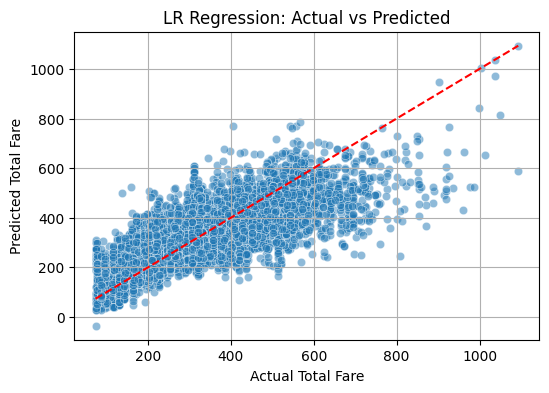

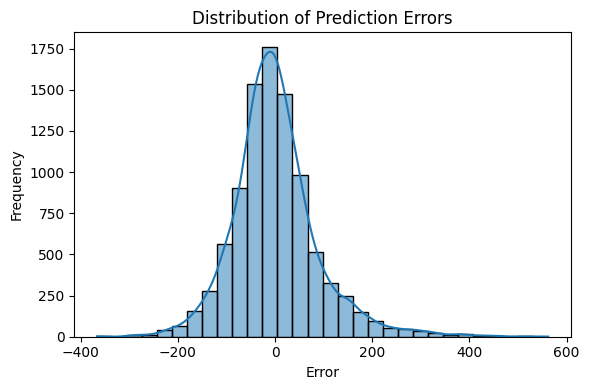

In [ ]:
# ----- Linear Regression -----

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train Linear Regression
lr_module = LinearRegression()
lr_module.fit(X_train, y_train)
y_pred = lr_module.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('-'*50)
print("Linear Regression Performance:")
print('-'*50)
print(f'R2 Score = {r2:.4f}')
print(f'MAE = {mae:.2f}')
print(f'MSE = {mse:.2f}')
print(f'RMSE = {rmse:.2f}')
print('-'*50)

# Visualization: Actual vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('LR Regression: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()
# Plot actual ticket price on the x-axis vs predicted price on y-axis
# Visualization the predicttions genearally close to raeal values or not

# Visualization: Distribution of Errors
errors = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

--------------------------------------------------
KNN Regressor Performance: 
--------------------------------------------------
Best Parameters = {'weights': 'uniform', 'p': 1, 'n_neighbors': 1}
R2 Score   = 0.8341
MAE  = 20.11
MSE = 3548.68
RMSE = 59.57
--------------------------------------------------


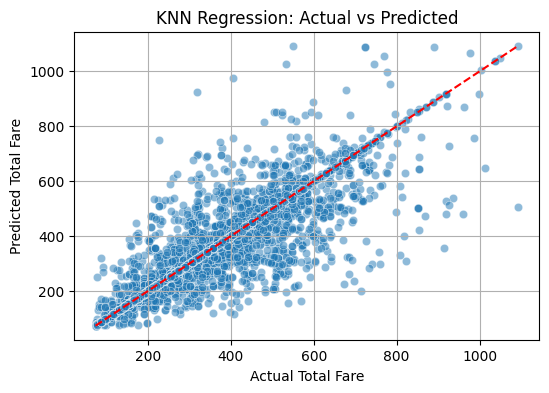

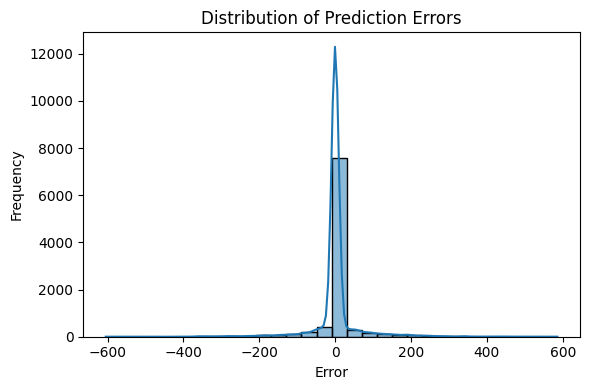

In [ ]:
# ----- K-nearest Neighbours -----

# Create a base KNN model
knn = KNeighborsRegressor()

# Define parameter distributions to sample from randomly
param_dist = {
    'n_neighbors': list(range(1, 5)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Perform randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search model
random_search.fit(X_processed, y)

# Use for split small portion of sample for initial testing (not use in final ver)
# X_sample = X_processed[:200]
# y_sample = y[:200]
# random_search.fit(X_sample, y_sample)

# Extract the best KNN model
best_model = random_search.best_estimator_

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train the best KNN model on training data
best_model.fit(X_train, y_train)

# Predict the target on the test set
y_pred = best_model.predict(X_test)

# Evaluate performance using MAE, RMSE, and R2 score
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print model performance metrics
print('-'*50)
print("KNN Regressor Performance: ")
print('-'*50)
print(f"Best Parameters = {random_search.best_params_}")
print(f"R2 Score   = {r2:.4f}")
print(f"MAE  = {mae:.2f}")
print(f'MSE = {mse:.2f}')
print(f"RMSE = {rmse:.2f}")
print('-'*50)

# Visualization: Actual vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('KNN Regression: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()

# Visualization: Distribution of Errors
errors = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
--------------------------------------------------
Random Forest Regressor Performance:
--------------------------------------------------
Best Parameters = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
R2 Score   = 0.8722
MAE  = 29.15
RMSE = 52.30
MSE = 2735.10
--------------------------------------------------


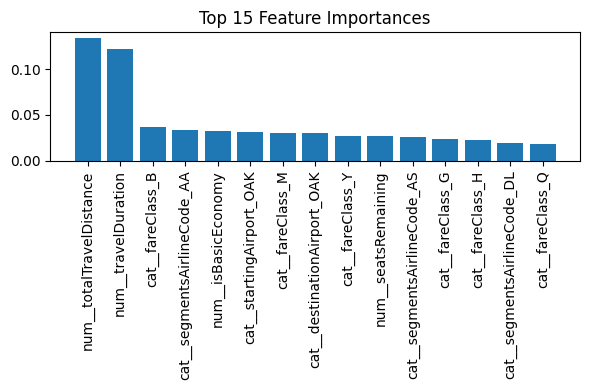

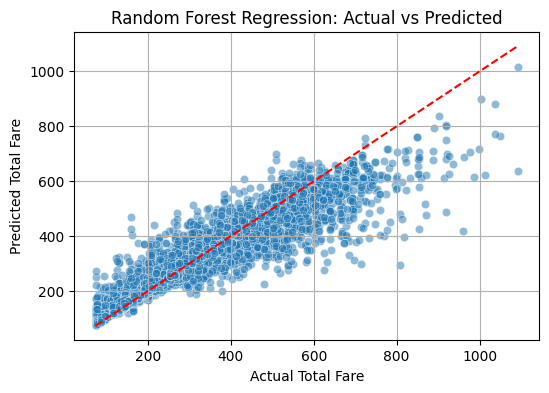

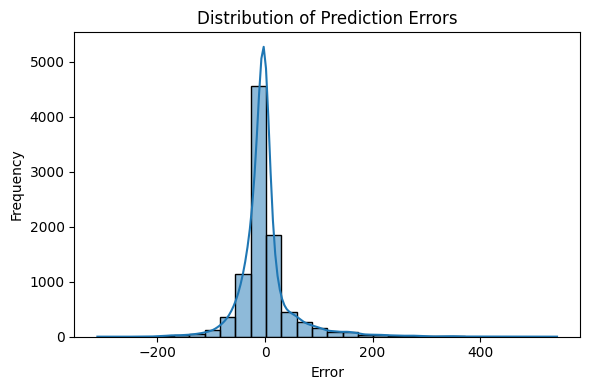

In [ ]:
# ----- Random Forest -----

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter distributions to search
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt','log2']
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    verbose=1,
    scoring='neg_mean_absolute_error',
    n_jobs=-1, # to use all cores
    random_state=42
)

# Fit on the preprocessed features
random_search.fit(X_processed, y)

# Use for split small portion of sample for initial testing (not use in final ver)
# X_sample = X_processed[:200]
# y_sample = y[:200]
# random_search.fit(X_sample, y_sample)

# Best model
best_rf_model = random_search.best_estimator_

# Split data into training and testing sets (80% train set and 20% test set)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train the best model on training data
best_rf_model.fit(X_train, y_train)

# Predict the target on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate performance using MAE, MSE, RMSE, and R2 score
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print model performance metrics
print('-'*50)
print("Random Forest Regressor Performance:")
print('-'*50)
print(f"Best Parameters = {random_search.best_params_}")
print(f"R2 Score   = {r2:.4f}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f'MSE = {mse:.2f}')
print('-'*50)

#visualization: Top 15 Useful Features
importances = best_rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(6,4))
plt.bar(range(15), importances[sorted_idx[:15]])
plt.xticks(range(15), feature_names[sorted_idx[:15]], rotation=90)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Random Forest Regression: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()

# Visualization: Distribution of Errors
errors = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()